# Import Libraries

In [ ]:
import json
import os
import numpy as np
import random
import torch
import torch.nn as nn
from transformers import ViTModel, ViTImageProcessor, GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import gc
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading Dataset

In [ ]:
# Load the dataset
data_path = "/kaggle/input/vqa-new-all/vizwiz_combined.csv"
df = pd.read_csv(data_path)

In [ ]:
df.head()

,image_path,question,answer
0,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What's the name of this product?,basil leaves
1,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Can you tell me what is in this can please?,coca cola
2,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Is this enchilada sauce or is this tomatoes? ...,tomatoes
3,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is the captcha on this screenshot?,t36m
4,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is this item?,solar garden light


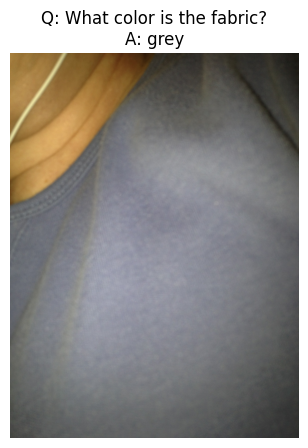

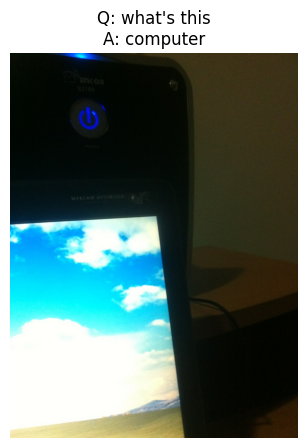

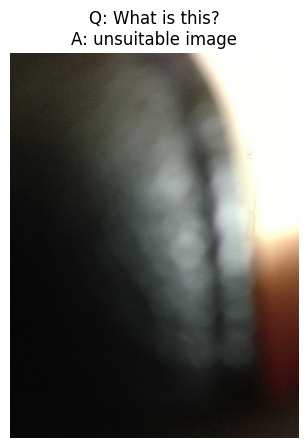

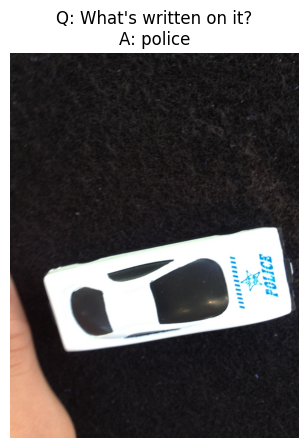

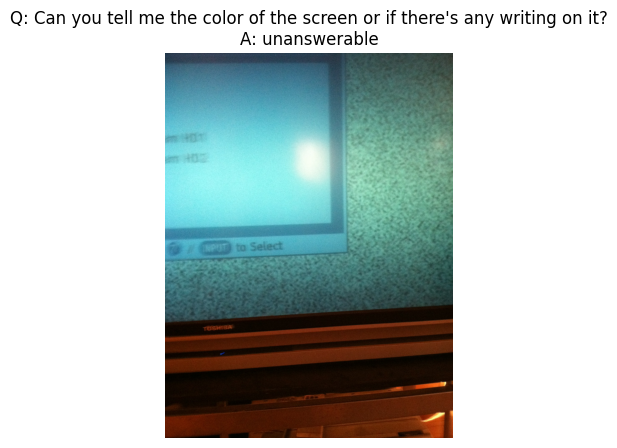

In [ ]:
randos = []
for i in range(5):
    randos.append(random.randint(0, 24842))

# Sample images with questions and answers
for i in randos:
    sample = df.iloc[i]
    img = Image.open(sample["image_path"])
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Q: {sample['question']}\nA: {sample['answer']}")
    plt.axis("off")
    plt.show()

In [ ]:
# Dataset Splitting
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 19873, Val size: 2484, Test size: 2485


In [ ]:
train_df.to_csv("/kaggle/working/train.csv", index=False)
val_df.to_csv("/kaggle/working/val.csv", index=False)
test_df.to_csv("/kaggle/working/test.csv", index=False)

# Custom Dataset

In [ ]:
# === Dataset ===
class VQAGPT2Dataset(Dataset):
    def __init__(self, csv_path, tokenizer, feature_extractor, max_length=64):
        self.data = pd.read_csv(csv_path)
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        question, answer = row["question"], row["answer"]
        pixel_values = self.feature_extractor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        full_text = f"Question: {question} Answer: {answer}"
        input_ids = self.tokenizer(full_text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)["input_ids"].squeeze(0)
        labels = input_ids.clone()

        q_prompt = f"Question: {question} Answer:"
        q_len = len(self.tokenizer(q_prompt, return_tensors="pt")["input_ids"][0]) - 1
        labels[:q_len] = -100

        labels = torch.cat([torch.tensor([-100]), labels])

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "labels": labels,
            "question": question,
            "answer": answer,
            "image_path": row["image_path"]
        }


# **VIT_GPT2_MODEL**

In [ ]:
# === Model Definition ===
class VQA_GPT2_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.image_proj = nn.Linear(self.image_encoder.config.hidden_size, 768)
        self.text_decoder = GPT2LMHeadModel.from_pretrained("gpt2")
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.text_decoder.resize_token_embeddings(len(self.tokenizer))

    def forward(self, pixel_values, input_ids=None, attention_mask=None, labels=None):
        image_feat = self.image_encoder(pixel_values=pixel_values).last_hidden_state[:, 0, :]
        image_embed = self.image_proj(image_feat).unsqueeze(1)

        if input_ids is not None:
            text_embeds = self.text_decoder.transformer.wte(input_ids)
            input_embeds = torch.cat([image_embed, text_embeds], dim=1)

            if attention_mask is not None:
                image_mask = torch.ones((attention_mask.shape[0], 1), device=attention_mask.device)
                attention_mask = torch.cat([image_mask, attention_mask], dim=1)

            return self.text_decoder(
                inputs_embeds=input_embeds,
                attention_mask=attention_mask,
                labels=labels
            )
        else:
            return image_embed

    def generate_answer(self, image, question, tokenizer, feature_extractor, device, max_new_tokens=30):
        self.eval()
        pixel_values = feature_extractor(images=image, return_tensors="pt")["pixel_values"].to(device)
        image_embed = self(pixel_values)
        input_ids = tokenizer(question, return_tensors="pt")["input_ids"].to(device)
        question_embed = self.text_decoder.transformer.wte(input_ids)
        input_embeds = torch.cat([image_embed, question_embed], dim=1)
        attention_mask = torch.ones(input_embeds.shape[:2], dtype=torch.long).to(device)

        output = self.text_decoder.generate(
            inputs_embeds=input_embeds,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

        return tokenizer.decode(output[0], skip_special_tokens=True)

In [ ]:
# === Semantic Accuracy ===
model_st = SentenceTransformer("all-MiniLM-L6-v2")

def compute_semantic_similarity(preds, refs):
    emb_preds = model_st.encode(preds, convert_to_tensor=True)
    emb_refs = model_st.encode(refs, convert_to_tensor=True)
    sims = cosine_similarity(emb_preds.cpu(), emb_refs.cpu()).diagonal()
    return np.mean(sims)


In [ ]:
def train_one_epoch(model, dataloader, optimizer, tokenizer, feature_extractor, device, scaler):
    model.train()
    total_loss = 0
    all_preds, all_refs = [], []
    for batch in tqdm(dataloader, desc="Train"):
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(pixel_values=pixel_values, input_ids=input_ids, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()

        # For semantic accuracy
        with torch.no_grad():
            for i in range(len(batch["question"])):
                image = Image.open(batch["image_path"][i]).convert("RGB")
                question = batch["question"][i]
                answer = batch["answer"][i]
                prediction = model.generate_answer(image, f"Question: {question} Answer:", tokenizer, feature_extractor, device)
                all_preds.append(prediction)
                all_refs.append(answer)

        del pixel_values, input_ids, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    semantic_acc = compute_semantic_similarity(all_preds, all_refs)
    return total_loss / len(dataloader), semantic_acc

In [ ]:
def evaluate(model, dataloader, tokenizer, feature_extractor, device):
    model.eval()
    total_loss = 0
    all_preds, all_refs, samples = [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, input_ids=input_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            for i in range(len(batch["question"])):
                image = Image.open(batch["image_path"][i]).convert("RGB")
                question = batch["question"][i]
                answer = batch["answer"][i]
                prediction = model.generate_answer(image, f"Question: {question} Answer:", tokenizer, feature_extractor, device)
                all_preds.append(prediction)
                all_refs.append(answer)
                if len(samples) < 10:
                    samples.append((question, answer, prediction))
            del pixel_values, input_ids, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

    semantic_acc = compute_semantic_similarity(all_preds, all_refs)
    return total_loss / len(dataloader), semantic_acc, samples


# **TRAINING THE MODEL**

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from transformers.utils import logging
logging.set_verbosity_error()


In [ ]:
# === Main Execution ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQA_GPT2_Model().to(device)
tokenizer = model.tokenizer
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
train_dataset = VQAGPT2Dataset("/kaggle/working/train.csv", tokenizer, feature_extractor)
val_dataset = VQAGPT2Dataset("/kaggle/working/val.csv", tokenizer, feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scaler = torch.cuda.amp.GradScaler()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(3):
    print(f"\n📘 Epoch {epoch+1}/3")

    # Train the model for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, tokenizer, feature_extractor, device, scaler)

    # Evaluate the model on the validation set
    val_loss, val_acc, samples = evaluate(model, val_loader, tokenizer, feature_extractor, device)

    print(f"Train Loss: {train_loss:.4f}, Train Semantic Accuracy: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Validation Semantic Accuracy: {val_acc:.4f}")

    # Display random samples from the validation set
    for q, a, p in random.sample(samples, min(3, len(samples))):
        print(f"\n📸 Question: {q}\n✅ Answer: {a}\n🤖 Predicted: {p}")

    # Append the current epoch's statistics to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save the model state, optimizer state, and epoch statistics
    epoch_checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    checkpoint_path = f"epoch_{epoch+1}_checkpoint.pth"
    torch.save(epoch_checkpoint, checkpoint_path)
    print(f"🔒 Model checkpoint for Epoch {epoch+1} saved to {checkpoint_path}")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/tmp/ipykernel_31/825784693.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



📘 Epoch 1/3


Train: 100%|██████████| 4969/4969 [1:36:08<00:00,  1.16s/it]


Batches:   0%|          | 0/622 [00:00<?, ?it/s]

Batches:   0%|          | 0/622 [00:00<?, ?it/s]

Validation: 100%|██████████| 621/621 [10:09<00:00,  1.02it/s]


Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1761, Train Semantic Accuracy: 0.5030
Val Loss:   0.1361, Validation Semantic Accuracy: 0.5187

📸 Question: What does this can say?
✅ Answer: classic roast
🤖 Predicted:  unanswerable

📸 Question: Hi. Can you give me the serial number of this device? 
✅ Answer: no
🤖 Predicted:  unsuitable

📸 Question: What breed of dog is this?
✅ Answer: unsuitable
🤖 Predicted:  unsuitable
🔒 Model checkpoint for Epoch 1 saved to epoch_1_checkpoint.pth

📘 Epoch 2/3


Train: 100%|██████████| 4969/4969 [1:32:23<00:00,  1.12s/it]


Batches:   0%|          | 0/622 [00:00<?, ?it/s]

Batches:   0%|          | 0/622 [00:00<?, ?it/s]

Validation: 100%|██████████| 621/621 [09:40<00:00,  1.07it/s]


Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1074, Train Semantic Accuracy: 0.5888
Val Loss:   0.1289, Validation Semantic Accuracy: 0.5451

📸 Question: What breed of dog is this?
✅ Answer: unsuitable
🤖 Predicted:  unsuitable

📸 Question: What color is this?
✅ Answer: brown
🤖 Predicted:  grey

📸 Question: Hi. Can you give me the serial number of this device? 
✅ Answer: no
🤖 Predicted:  unsuitable
🔒 Model checkpoint for Epoch 2 saved to epoch_2_checkpoint.pth

📘 Epoch 3/3


Train: 100%|██████████| 4969/4969 [1:30:53<00:00,  1.10s/it]


Batches:   0%|          | 0/622 [00:00<?, ?it/s]

Batches:   0%|          | 0/622 [00:00<?, ?it/s]

Validation: 100%|██████████| 621/621 [09:32<00:00,  1.08it/s]


Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0752, Train Semantic Accuracy: 0.6819
Val Loss:   0.1373, Validation Semantic Accuracy: 0.5605

📸 Question: What does this can say?
✅ Answer: classic roast
🤖 Predicted:  unanswerable

📸 Question: What color is this shirt?
✅ Answer: grey
🤖 Predicted:  white

📸 Question: What breed of dog is this?
✅ Answer: unsuitable
🤖 Predicted:  unsuitable
🔒 Model checkpoint for Epoch 3 saved to epoch_3_checkpoint.pth


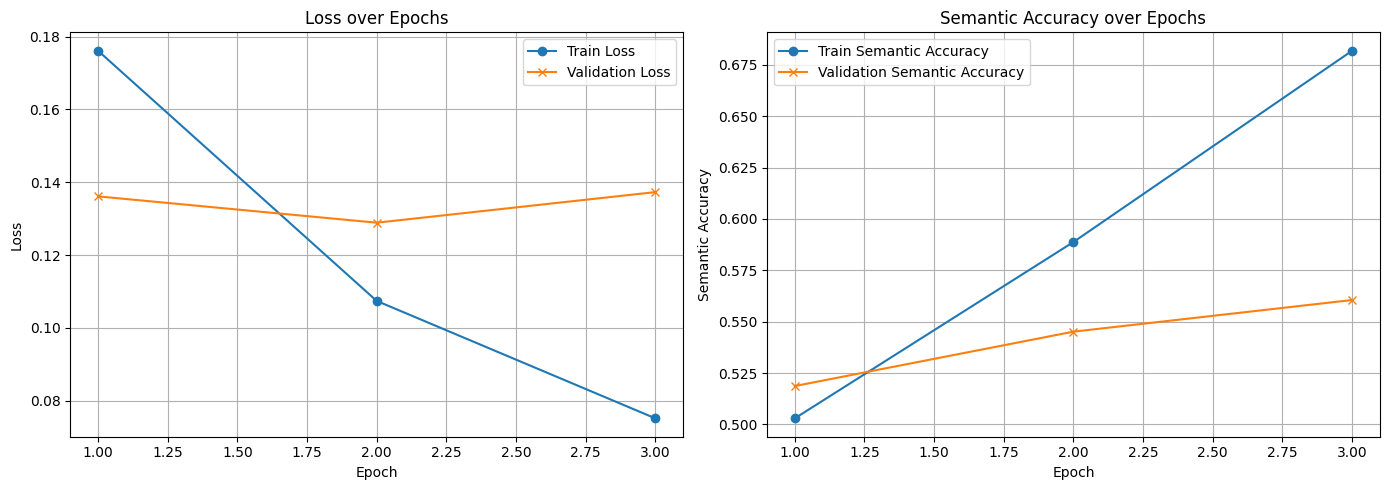

In [ ]:
import matplotlib.pyplot as plt

# Define epochs
epochs = list(range(1, len(train_losses) + 1))

# Plotting Loss over Epochs
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="x")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Semantic Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Semantic Accuracy", marker="x")
plt.title("Semantic Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Semantic Accuracy")
plt.grid()
plt.legend()

# Final adjustments for better layout
plt.tight_layout()
plt.show()


# Save Model

In [ ]:
# 🔐 Save model weights and tokenizer state
save_path = "/kaggle/working/vqa_vit_gpt2.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "tokenizer": model.tokenizer,
}, save_path)
print(f"✅ Model saved at: {save_path}")


✅ Model saved at: /kaggle/working/vqa_vit_gpt2.pth


# Evaluation on Test Dataset

In [ ]:
# Prepare the model for evaluation (disable dropout, batch norm updates)
model.eval()

# Make sure no gradients are calculated during testing (saves memory)
with torch.no_grad():
    test_dataset = VQAGPT2Dataset("/kaggle/working/test.csv", tokenizer, feature_extractor)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    # Evaluate the model on the test set
    test_loss, test_accuracy, samples = evaluate(model, test_loader, tokenizer, feature_extractor, device)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Semantic Accuracy: {test_accuracy:.4f}")

# Optionally, print some random test samples (question, ground truth answer, predicted answer)
for q, a, p in random.sample(samples, min(3, len(samples))):  # Show 3 random samples
    print(f"\n📸 Question: {q}\n✅ Answer: {a}\n🤖 Predicted: {p}")


Validation: 100%|██████████| 622/622 [10:32<00:00,  1.02s/it]


Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Test Loss: 0.1403
Test Semantic Accuracy: 0.5639

📸 Question: What does this say?
✅ Answer: back next
🤖 Predicted:  unsuitable image

📸 Question: What is this? 
✅ Answer: water
🤖 Predicted:  water bottle

📸 Question: What type of coffee is this?
✅ Answer: french roast
🤖 Predicted:  french vanilla


In [ ]:
print("\n📊 Final Comparison:")
print(f"Train Accuracy:     {train_accuracies[-1]:.4f}, Loss: {train_losses[-1]:.4f}")
print(f"Validation Accuracy:{val_accuracies[-1]:.4f}, Loss: {val_losses[-1]:.4f}")
print(f"Test Accuracy:      {test_accuracy:.4f}, Loss: {test_loss:.4f}")


📊 Final Comparison:
Train Accuracy:     0.6819, Loss: 0.0752
Validation Accuracy:0.5605, Loss: 0.1373
Test Accuracy:      0.5639, Loss: 0.1403


# INFERENCE

In [ ]:
from IPython.display import display
from IPython.display import Image as IPyImage
import ipywidgets as widgets
from PIL import Image
import torch

# 🔁 Reinitialize and load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQA_GPT2_Model().to(device)
checkpoint = torch.load("/kaggle/working/vqa_vit_gpt2.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
tokenizer = model.tokenizer
feature_extractor = AutoImageProcessor.from_pretrained("google/siglip-base-patch16-224")
print("✅ Model loaded and ready.")



/tmp/ipykernel_31/2251938794.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/vqa_vit_gpt2.pth", map_location=device)


✅ Model loaded and ready.


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# File upload widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)


FileUpload(value=(), accept='image/*', description='Upload')

✅ Image saved at: /kaggle/working/uploaded_image1.jpg


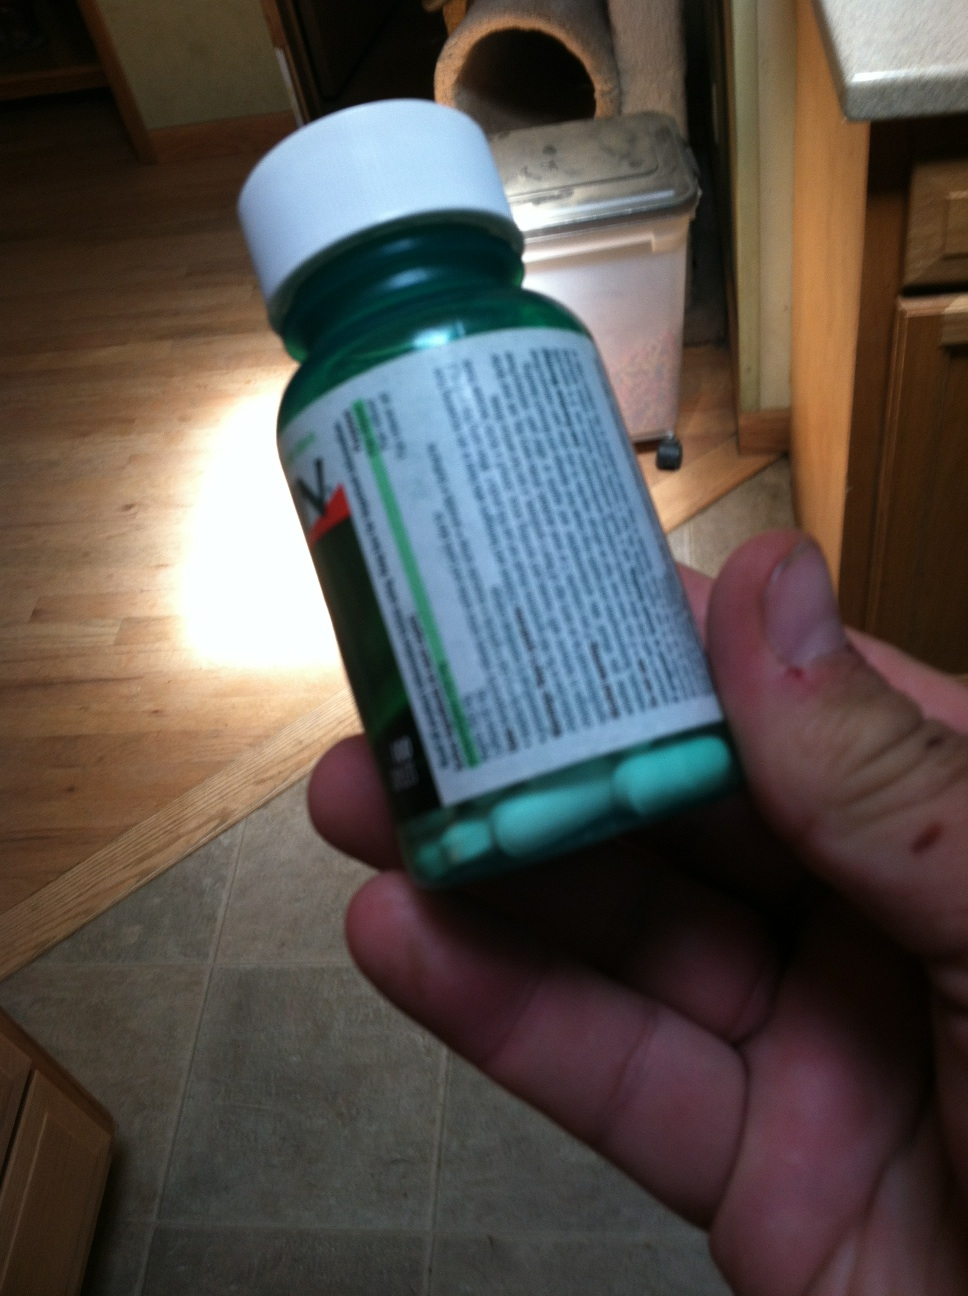

In [ ]:
import io
from PIL import Image
from IPython.display import display

# Validate upload
if uploader.value is None or len(uploader.value) == 0:
    raise Exception("❌ No image uploaded. Please upload an image.")

# Get uploaded image (Kaggle returns a tuple with one dict per file)
uploaded_info = uploader.value[0]
image_bytes = uploaded_info["content"]

# Convert to image
try:
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
except Exception as e:
    raise Exception("⚠️ Failed to open uploaded image. Please re-upload.") from e

# Save to /kaggle/working/
image_path = "/kaggle/working/uploaded_image1.jpg"
image.save(image_path)
print(f"✅ Image saved at: {image_path}")

# Display for visual confirmation
display(image)


In [ ]:
question = input("❓ Enter your question about the uploaded image: ")

❓ Enter your question about the uploaded image:  what is this medicine?


In [ ]:
# Format input
formatted_question = f"Question: {question} Answer:"

# Generate answer
predicted_answer = model.generate_answer(
    image=image,
    question=formatted_question,
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    device=device
)

# Display result
print(f"\n🖼️ Question: {question}\n🤖 Answer: {predicted_answer}")



🖼️ Question: what is this medicine?
🤖 Answer:  unanswerable
